# 3-1. 카메라 스티커앱 만들기 첫걸음

이번 코스를 통해

1. 카메라앱 만들기를 통해 동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근 의 기술을 다룹니다.
2. 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있습니다.

이번 시간의 목표입니다.

1. 얼굴인식 카메라의 흐름을 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리

# 3-2. 어떻게 만들까? 사진 준비하기

스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요합니다. 이 위치들을 찾아내는 기술을 랜드마크 landmark 또는 조정 alignment 이라고 합니다. 조금 더 큰 범위로는 keypoint detection 이라고 부르고 있습니다. 대부분의 face landmark 데이터셋은 눈, 코, 입과 턱을 포함하고 있습니다. 얼굴의 랜드마크를 찾아냈다면 머리의 위치를 예상하는 것은 쉽습니다. 눈과 코의 위치로부터 위로 떨어져 있는 정도를 데이터로부터 유추할 수 있을 겁니다.

따라서 우리는,

얼굴이 포함된 사진을 준비하고
사진으로부터 얼굴 영역 face landmark 를 찾아냅니다. (landmark를 찾기 위해서는 얼굴의 bounding box를 먼저 찾아야합니다.)
찾아진 영역으로 부터 머리에 왕관 스티커를 붙여넣겠습니다.

사진을 준비하자


우선 다음과 같이 작업 디렉토리 구조를 세팅합니다.

* mkdir -p ~/aiffel/camera_sticker/models   
* mkdir -p ~/aiffel/camera_sticker/images

사용할 디렉토리 구조는 아래와 같습니다. camera_sticker라는 작업 디렉토리 아래의 images 디렉토리에다가 image.jpg 으로 여러분만의 이미지를 저장해 주세요.

aiffel  
├── camera_sticker  
        └── models  
        └── images  
                └── image.jpg

여러분들의 이미지 뿐 아니라, 함께 활용할 왕관 이미지들도 미리 저장해 둡시다.

*  wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/king.png
*  wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/hero.png
*  mv king.png hero.png ~/aiffel/camera_sticker/images

아래는 오늘 활용해야 할 이미지 처리 관련 패키지들입니다. opencv, cmake, dlib 설치가 안 돼 있다면 터미널을 열어 아래와 같이 설치해 주세요. 👽

* pip install opencv-python
* pip install cmake
* pip install dlib

### 환경설정, 패키지 설치

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")  #이미지 잘 읽어오는가 확인

🌫🛸


이미지 처리를 위해 opencv 와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어옵니다.
준비한 이미지를 읽습니다.

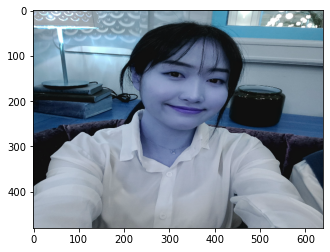

In [2]:
import os
my_image_path = os.getenv('HOME')+'/project/AIFFEL/E03_CameraSticker/images/IMG_20201024_202505_572.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x480의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

편의를 위해 이미지 크기를 변경합니다. 위에서는 640x360의 VGA 크기(16:9)로 고정했습니다. 이미지 가로 세로의 비율에 따라 알맞게 변경해주세요. 만약 종횡비(가로 세로 비율) 가 4:3이라면 640x480 으로 변경해주시면 됩니다.  
  
그런데 좀 이상하지 않으신가요? 사진이 잘 나온것 같긴 한데 색상이 좀 이상합니다. 얼굴 색에 왜이렇게 푸른빛이 감도는 걸까요?   
이것은 opencv의 특징 때문입니다. 오늘 사용하게 될 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용합니다. 그런데 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용합니다. 그래서 여러분의 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력된 것입니다. 그래서, opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 아래와 같은 색깔 보정처리를 해주게 됩니다

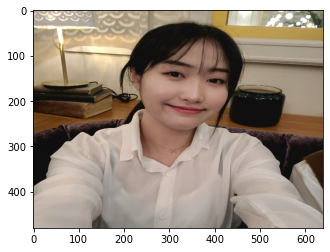

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 3-3. 얼굴 검출 face detection  

Object detection 기술을 이용해서 얼굴의 위치를 찾겠습니다. 이번 시간에는 빠르게 만들기 위해 학습 없이 공개되어 있는 패키지를 사용하겠습니다.  
  
dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾습니다. HOG와 SVM의 자세한 알고리즘은 아래 링크를 참고해 주세요. (한국어 버전도 있습니다.)

In [4]:
# 그럼 dlib을 활용해 hog detector를 선언해 보겠습니다.
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


In [5]:
#detector를 이용해서 얼굴의 bounding box를 추출합니다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었습니다.  
  
detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. 이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다.  
이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 이미지 피라미드에 대한 내용은 아래 링크를 참고해 주세요.   
찾은 얼굴을 화면에 출력해보겠습니다.

rectangles[[(241, 68) (464, 291)]]


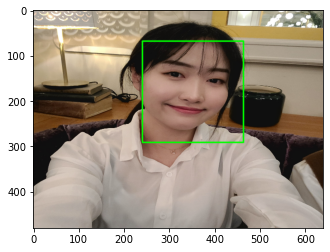

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [24]:
temp = list((2,3,4,5))

In [25]:
temp

[2, 3, 4, 5]

dlib detector 는 dlib.rectangles 타입의 객체를 반환합니다.

dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.

dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있습니다. 더 자세한 정보는 dlib docs를 참고해주세요.

# 3-4. 얼굴 랜드마크 face landmark  

앞서 말씀 드린 것처럼 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요합니다. 이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 합니다. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용합니다.

#### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식을 다룹니다.



#### Dlib landmark localization
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.  
  
이 때 점의 개수는 데이터셋과 논문마다 다릅니다. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용합니다.   
Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 을 제공합니다. 학습 알고리즘은 regression tree의 앙상블 모델을 사용 했습니다. 자세한 내용이 궁금하신 분들은 2014년 CVPR (Computer Vision and Pattern Recognition) 에 발표한 논문One Millisecond Face Alignment with an Ensemble of Regression Trees 을 참고해 주세요. 오늘은 알고리즘을 이해하지 않아도 괜찮습니다.   
Dlib의 제공되는 모델을 사용해보겠습니다. 먼저 공개되어 있는 weight file을 다운로드 받습니다. 위치는 root 디렉토리의 models 디렉토리 입니다. 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용하겠습니다.


* wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
* mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
* cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [7]:
# 저장한 landmark 모델 불러오기

import os
model_path = os.getenv('HOME')+'/project/AIFFEL/E03_CameraSticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환합니다.

In [8]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다. 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다.

랜드마크를 영상에 출력해 보겠습니다.

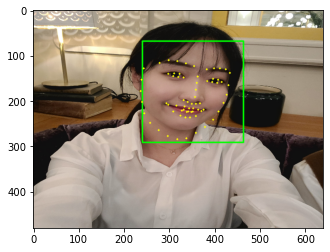

In [9]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3-5. 스티커 적용하기
랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌우면 될 것 같습니다. 구현 방법은 여러 가지가 있습니다. 위 그림처럼 코 중심을 기준으로 높이 x 이상에 그려도 되고 눈썹 위 n 픽셀 위에 스티커를 구현해도 됩니다.  
  
중요한 것은 얼굴 위치, 카메라의 거리에 따라 픽셀 x 가 다르기 때문에 비율로 계산을 해줘야 합니다. 계산할 수치는 두 가지 입니다.  

스티커 위치
$$x= x_{nose}$$
$$y= y_{nose} - \frac{width}{2}$$


스티커 크기  
$$width = height = width_{bbox}$$

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(357, 191)
(x,y) : (357,79)
(w,h) : (224,224)


In [28]:
print(landmark[30][1])

191


제 얼굴 이미지에서는 코의 중심점이 (357, 191) 로 나오네요.

In [11]:
import os
sticker_path = os.getenv('HOME')+'/project/AIFFEL/E03_CameraSticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize 합니다.
원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.

In [12]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (245,-145)


출력해보면 문제가 생기는 것을 확인할 수 있습니다. y축 좌표의 값이 음수가 계산 되었습니다.   
음수는 무슨 의미일까요?  
opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다. 따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.

In [13]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(79, 224, 3)


top 의 y 좌표는 원본 이미지의 경계 값으로 수정합니다.

In [26]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (245,0)


원본 이미지에 스티커를 적용합니다.


In [15]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. 따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다. img_show 에 다시 적용하겠습니다.

결과 이미지를 출력하면,

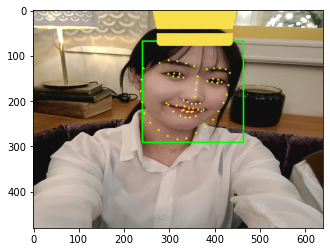

In [16]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

짠~ 스티커 기본 기능이 완성 되었습니다.

bounding box와 landmark를 제거하고 최종 결과만 출력해 봅시다. img_show 대신, 지금까지 아껴 두었던 img_rgb를 활용할 것입니다.


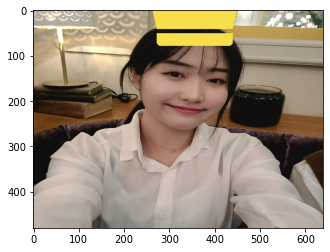

In [17]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()